In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device: ', device)

Device:  cuda


In [ ]:
N = 20
init_random = torch.rand((N,N,N)).to(device)
lattice_p = torch.zeros((N,N,N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)

In [ ]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1)
    kern[1][1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattice * conv3d(lattice.float(), kern, padding='same')
    return arr

def get_energy(lattice):
    # applies the nearest neighbours summation
    return get_energy_arr(lattice).sum(axis=(2,3,4)).squeeze()

def get_dE_arr(lattice):
    return -2*get_energy_arr(lattice)

In [ ]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        k = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3,4))/N**3)
    return torch.vstack(avg_spins), torch.vstack(energies)

In [ ]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    spins_std = torch.std(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, spins_std, energies_avg, energies_std

In [ ]:
BJs = 1/torch.linspace(2, 6, 40).to(device)
spins_avg_p, spins_std, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

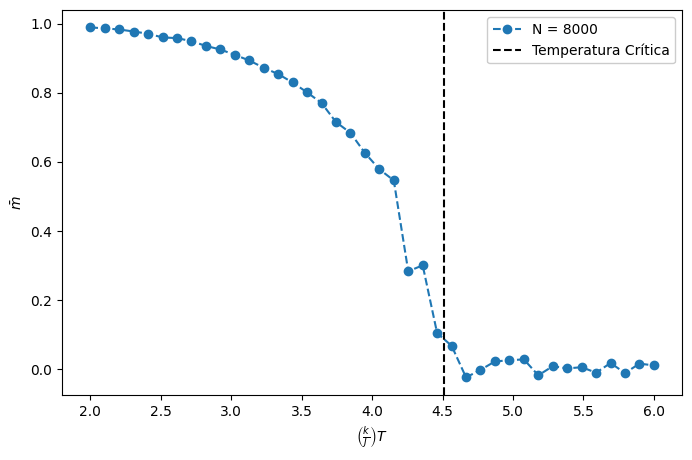

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label=f'N = {N**3}')
plt.axvline(1 / 0.221654626, color='k', ls='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

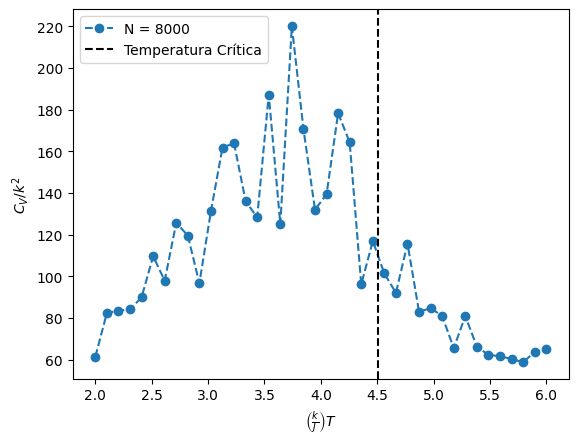

In [ ]:
plt.plot(1/BJs.cpu(), E_stds_p.cpu()*BJs.cpu(), '--o', label=f'N = {N**3}')
plt.axvline(1 / 0.221654626, color='k', ls='--', label='Temperatura Crítica')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

In [ ]:
from time import time

import pandas as pd

N=421875, time=20.926450967788696s
N=1000000, time=52.098938941955566s


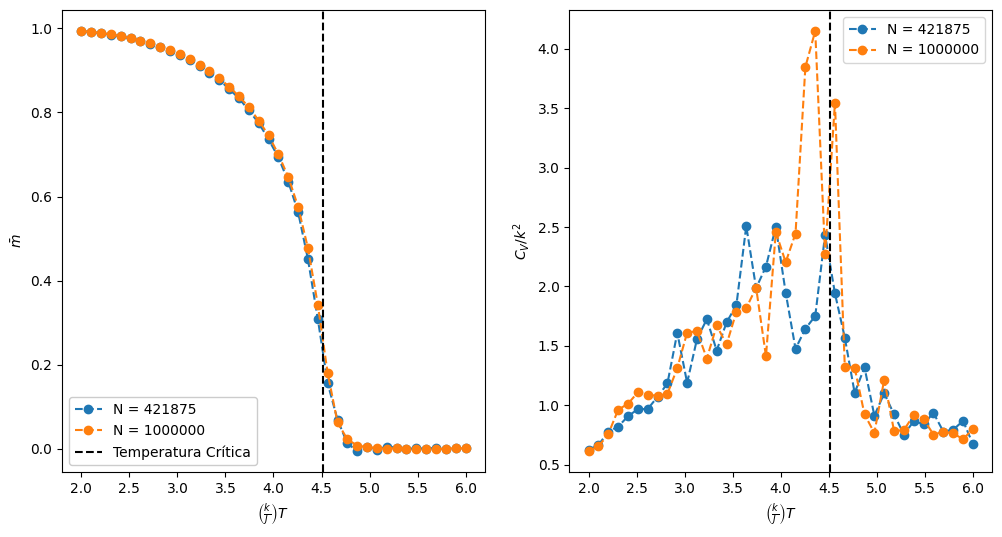

In [ ]:
data = pd.DataFrame() # Creamos un data frame donde guardaremos los resultados de la simulación

plt.figure(figsize=(12,6))

BJs = 1/torch.linspace(2, 6, 40).to(device)
data['BJs'] = BJs.cpu().numpy() # Guardamos los valores de BJs en el data frame
for N in [75, 100]:
  init_random = torch.rand((N,N,N)).to(device)
  lattice_p = torch.zeros((N,N,N)).to(device)
  lattice_p[init_random>=0.25] = 1
  lattice_p[init_random<0.25] = -1
  lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)
  inicio = time()
  spins_avg_p,spins_std, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)
  data['spins_avg_p_N='+str(N**3)] = spins_avg_p.cpu().numpy()
  data['spins_std_N='+str(N**3)] = spins_std.cpu().numpy()
  data['E_means_p_N='+str(N**3)] = E_means_p.cpu().numpy()
  data['E_stds_p_N='+str(N**3)] = E_stds_p.cpu().numpy()
  print(f'N={N**3}, time={time()-inicio}s')
  plt.subplot(1,2,1)
  plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label=f'N = {N**3}')
  plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
  plt.ylabel(r'$\bar{m}$')

  plt.subplot(1,2,2)
  plt.plot(1/BJs.cpu(), E_stds_p.cpu()*BJs.cpu()/N**(3/2), '--o', label=f'N = {N**3}')
  plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
  plt.ylabel(r'$C_V / k^2$')
plt.legend()


plt.axvline(1 / 0.221654626, color='k', ls='--', label='Temperatura Crítica')
plt.subplot(1,2,1)

plt.axvline(1 / 0.221654626, color='k', ls='--', label='Temperatura Crítica')
plt.legend(facecolor='white', framealpha=1)
plt.show()

data.to_csv('ising3D_data.csv', index=False) # Guardamos el data frame en un archivo csv

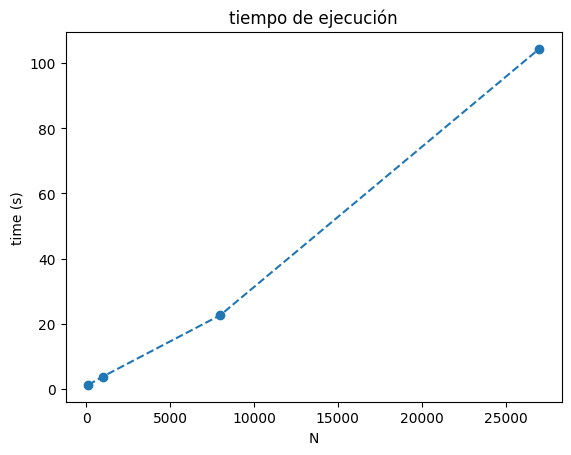

In [ ]:
plt.plot([125,1000,8000,27000], [1.26,3.83,22.67,104.36], '--o')
plt.title('tiempo de ejecución')
plt.ylabel('time (s)')
plt.xlabel('N')
plt.show()